# 📊 고객 세분화(Customer Segmentation) 데이터 명세서

본 데이터셋은 고객의 최근 구매 행동, 결제 특성 및 디지털 채널 활동성을 분석하여 군집화(Clustering) 모델을 구축하기 위해 설계되었습니다.

---

## 1. 변수 정의서 (Data Dictionary)

| 변수명 (Column) | 설명 (Description) | 데이터 타입 | 유효 범위 / 단위 |
| :--- | :--- | :--- | :--- |
| **Recency_Days** | 마지막 구매 후 경과일 | Integer | 일(Day) 단위 (작을수록 최신) |
| **Frequency_90D** | 최근 90일간 총 구매 횟수 | Integer | 회(Count) |
| **Monetary_90D** | 최근 90일간 총 구매 금액 | Float | 원(KRW) |
| **Avg_Basket** | 평균 객단가 (1회 결제 시 평균 금액) | Float | 원(KRW) |
| **Discount_Ratio** | 전체 구매 중 할인 적용 품목 비율 | Float | 0.0 ~ 1.0 |
| **Return_Ratio** | 전체 주문 대비 반품/환불 비율 | Float | 0.0 ~ 1.0 |
| **Web_Visits_30D** | 최근 30일간 웹사이트 방문 횟수 | Integer | 회(Count) |
| **App_Sessions_30D** | 최근 30일간 모바일 앱 실행 횟수 | Integer | 회(Count) |
| **Review_Score** | 고객이 남긴 리뷰의 평균 평점 | Float | 1.0 ~ 5.0 |
| **Region** | 고객 거주 지역 | Categorical | 서울, 경기, 부산 등 (범주형) |

---

## 2. 데이터 전처리 가이드 (Pre-processing)

군집 분석(K-Means 등)을 수행하기 전에 아래와 같은 전처리가 권장됩니다.

1. **스케일링 (Scaling)**
   - `Monetary_90D`와 `Discount_Ratio`는 값의 단위 차이가 매우 큽니다. 
   - 거리 기반 알고리즘 사용 시 **StandardScaler** 또는 **MinMaxScaler** 적용이 필수적입니다.

2. **범주형 변수 처리 (Encoding)**
   - `Region` 변수는 모델 입력 전 **One-Hot Encoding** 또는 **Label Encoding** 처리가 필요합니다.
   - 데이터가 너무 세분화되어 있다면 '수도권/비수도권' 등으로 그룹화하여 차원을 축소할 수 있습니다.

3. **이상치 처리 (Outlier Detection)**
   - 초고액 자산가나 대량 구매 사업자 등 `Monetary_90D`가 극단적으로 높은 데이터는 군집의 왜곡을 방지하기 위해 별도로 분리하거나 처리해야 합니다.

---

> **Note:** 위 데이터는 고객의 충성도(Loyalty)와 가격 민감도(Price Sensitivity)를 파악하는 데 최적화되어 있습니다.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 데이터 로드
df = pd.read_csv("../../data/customer_segments.csv")


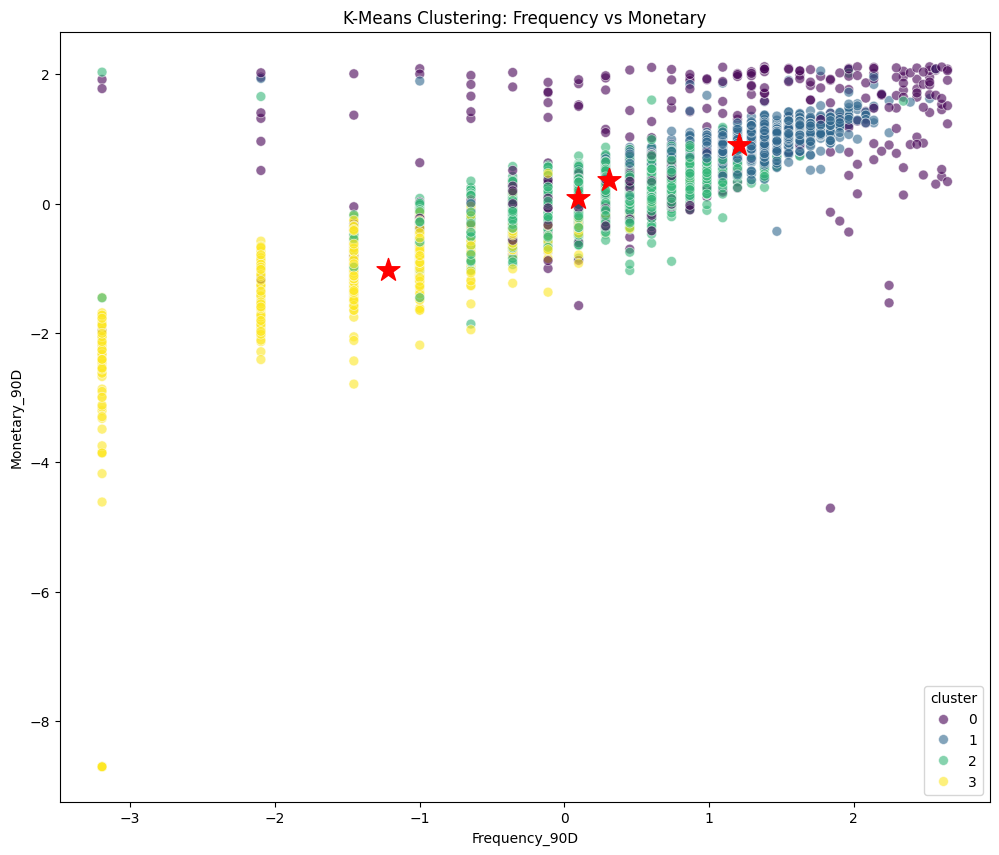

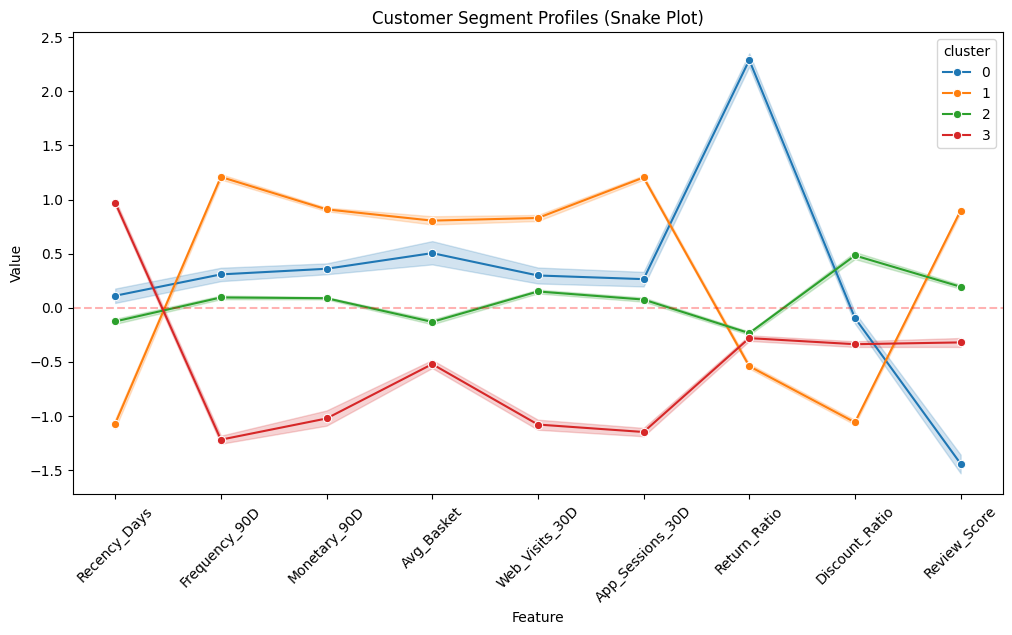

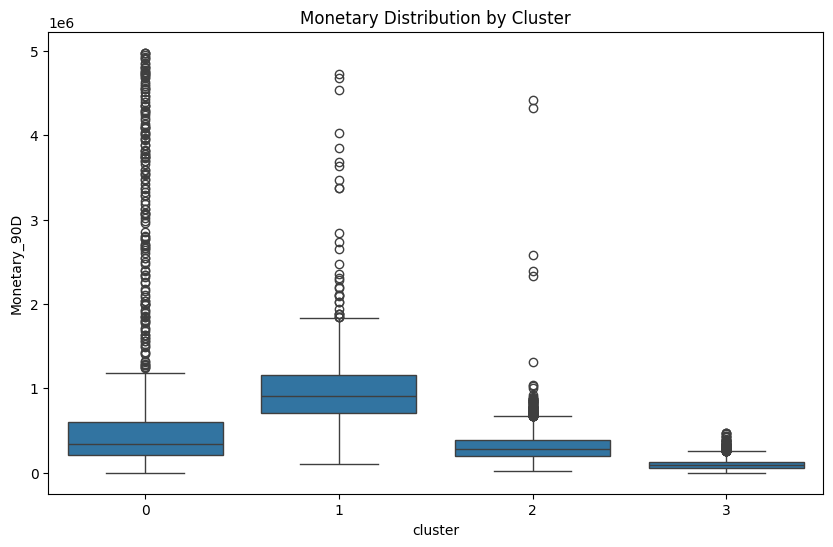

In [8]:
# 2. 전처리: 쏠림이 심한 컬럼에 로그 변환 적용
# Monetary, Frequency, Recency 등 0이 포함될 수 있으므로 log1p 사용
log_features = [
    "Recency_Days",
    "Frequency_90D",
    "Monetary_90D",
    "Avg_Basket",
    "Web_Visits_30D",
    "App_Sessions_30D",
    "Return_Ratio",
]
df_prep = df.copy()
for col in log_features:
    df_prep[col] = np.log1p(df[col])

# 분석에 사용할 최종 특성 선택
model_features = log_features + ["Discount_Ratio", "Review_Score"]
X = df_prep[model_features]

# 3. 스케일링 (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. K-Means 모델 생성 및 학습 (K=4로 가정)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# 5. 시각화: 스네이크 플롯 (Snake Plot)
df_scaled = pd.DataFrame(X_scaled, columns=model_features)
df_scaled["cluster"] = df["cluster"]
df_melted = df_scaled.melt(id_vars=["cluster"], var_name="Feature", value_name="Value")

plt.figure(figsize=(12, 10))

# x에 Frequency, y에 Monetary를 넣습니다.
sns.scatterplot(
    x="Frequency_90D",
    y="Monetary_90D",
    hue="cluster",
    data=df_scaled,
    palette="viridis",
    s=50,
    alpha=0.6,
    legend="full",
)

# 중심점(Centroids) 표시
# 주의: kmeans.cluster_centers_의 인덱스는 features 리스트의 순서와 같습니다.
# 만약 Frequency가 1번째, Monetary가 2번째 컬럼이었다면 아래와 같이 지정합니다.
plt.scatter(
    kmeans.cluster_centers_[:, 1],
    kmeans.cluster_centers_[:, 2],
    s=300,
    c="red",
    marker="*",
    label="Centroids",
)

plt.title("K-Means Clustering: Frequency vs Monetary")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(
    x="Feature", y="Value", hue="cluster", data=df_melted, palette="tab10", marker="o"
)
plt.title("Customer Segment Profiles (Snake Plot)")
plt.xticks(rotation=45)
plt.axhline(0, color="red", linestyle="--", alpha=0.3)
plt.show()

# 6. 군집별 실제 구매 금액 확인 (박스플롯)
plt.figure(figsize=(10, 6))
sns.boxplot(x="cluster", y="Monetary_90D", data=df)
plt.title("Monetary Distribution by Cluster")
plt.show()

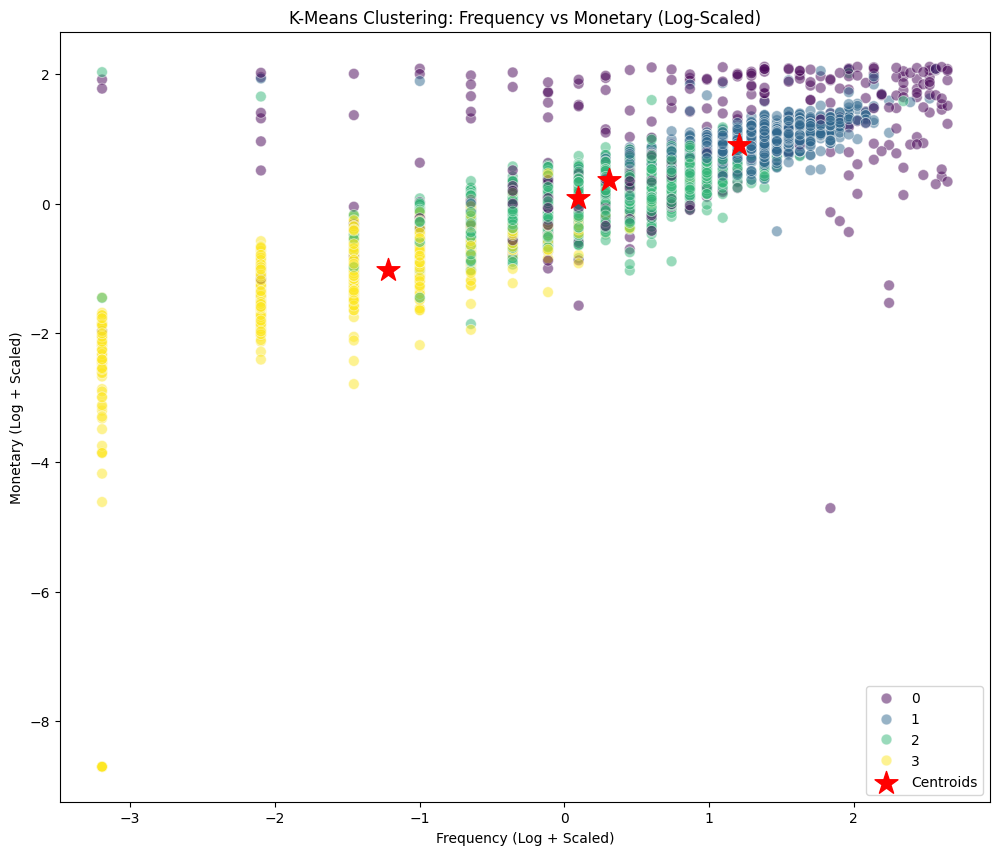

In [9]:
# 2. 전처리 (중요: 로그 변환을 해야 군집이 예쁘게 나옵니다)
log_features = [
    "Recency_Days",
    "Frequency_90D",
    "Monetary_90D",
    "Avg_Basket",
    "Web_Visits_30D",
    "App_Sessions_30D",
    "Return_Ratio",
]
df_prep = df.copy()
for col in log_features:
    df_prep[col] = np.log1p(df[col])

# 사용할 컬럼만 선택
features = log_features + ["Discount_Ratio", "Review_Score"]
X = df_prep[features]

# 3. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features)

# 4. K-Means 학습
# n_clusters는 엘보우 방법으로 정하는게 좋지만, 우선 4로 설정합니다.
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)
df_scaled["cluster"] = df["cluster"]

# 5. 시각화 (Frequency vs Monetary)
plt.figure(figsize=(12, 10))

# 산점도 그리기
sns.scatterplot(
    x="Frequency_90D",
    y="Monetary_90D",
    hue="cluster",
    data=df_scaled,
    palette="viridis",
    s=60,
    alpha=0.5,
    legend="full",
)

# 중심점(Centroids) 계산 및 표시
# fit할 때 'Frequency_90D'는 1번 인덱스, 'Monetary_90D'는 2번 인덱스였습니다.
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], s=300, c="red", marker="*", label="Centroids")

plt.title("K-Means Clustering: Frequency vs Monetary (Log-Scaled)")
plt.xlabel("Frequency (Log + Scaled)")
plt.ylabel("Monetary (Log + Scaled)")
plt.legend()
plt.show()

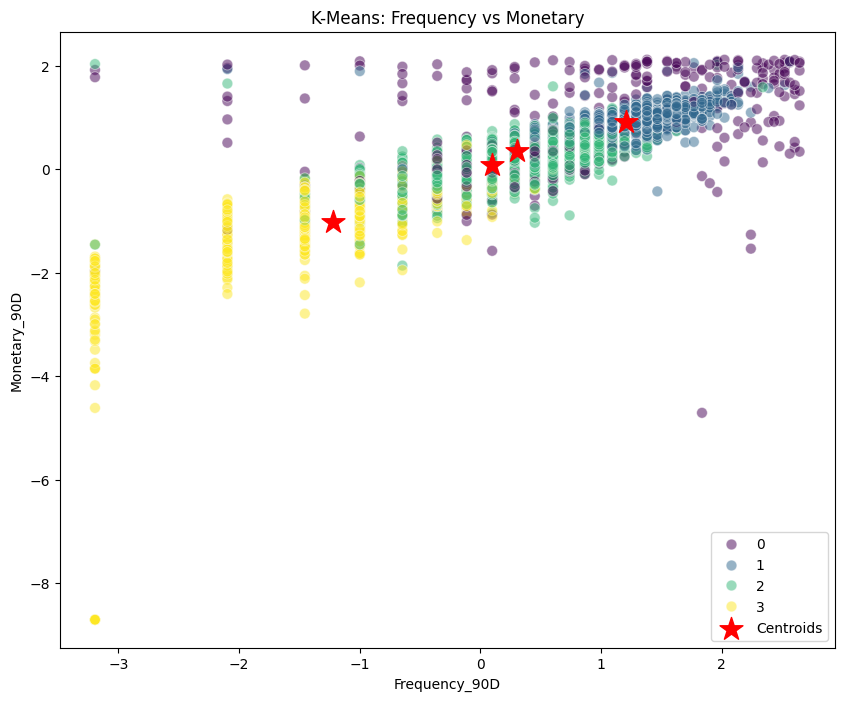

In [10]:
# 반드시 df_scaled(스케일링 된 데이터프레임)를 사용해야 합니다.
plt.figure(figsize=(10, 8))

# 1. 산점도: x와 y를 명확히 지정
sns.scatterplot(
    x="Frequency_90D",
    y="Monetary_90D",
    hue="cluster",
    data=df_scaled,
    palette="viridis",
    s=60,
    alpha=0.5,
)

# 2. 중심점: kmeans.fit에 넣었던 순서대로 가져와야 함
# features 리스트 순서: 0:Recency, 1:Frequency, 2:Monetary ...
centers = kmeans.cluster_centers_

# x축에 Frequency(1번), y축에 Monetary(2번)를 찍습니다.
plt.scatter(centers[:, 1], centers[:, 2], s=300, c="red", marker="*", label="Centroids")

plt.title("K-Means: Frequency vs Monetary")
plt.legend()
plt.show()